# Sona Davis
# Tutorial 4-Exoplanet exploration using Machine Learning-ANN
## Computational Astrobiology

In [2]:
# Imports and initial setup

import os
import warnings
import math
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import recall_score, classification_report, precision_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns


## Loading the Data

Load training and testing data from CSV files, and map labels to binary format.

In [4]:
train_data = pd.read_csv('/home/user/Documents/Sona-CA/exoTrain.csv').fillna(0)
test_data = pd.read_csv('/home/user/Documents/Sona-CA/exoTest.csv').fillna(0)

# Map labels: 2 -> 1 (exoplanet), 1 -> 0 (not exoplanet)
categ = {2: 1, 1: 0}
train_data.LABEL = train_data.LABEL.map(categ)
test_data.LABEL = test_data.LABEL.map(categ)

train_data.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


## Reducing Memory Usage

Define a function to reduce memory usage by downcasting data types.


In [6]:
def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        # print(col)
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
train_data = reduce_memory(train_data)
test_data = reduce_memory(test_data)


Memory usage of dataframe is 124.12 MB
Memory usage after optimization is: 62.04 MB
Decreased by 50.0%
Memory usage of dataframe is 13.91 MB
Memory usage after optimization is: 6.25 MB
Decreased by 55.1%


## Visualizing the Data Distribution


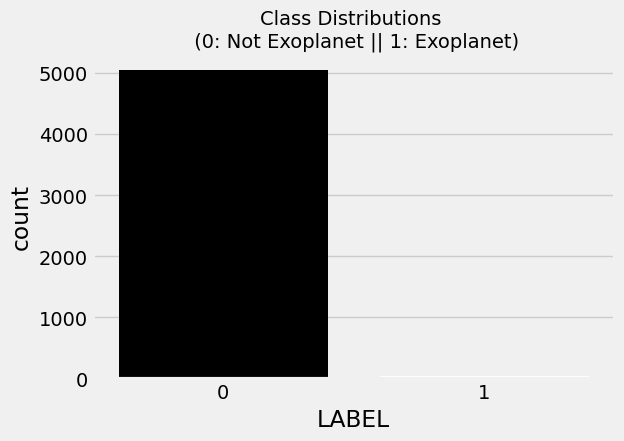

In [12]:
plt.figure(figsize=(6,4))
colors = ["0", "1"]
sns.countplot(x='LABEL', data=train_data, palette=colors)
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)
plt.show()


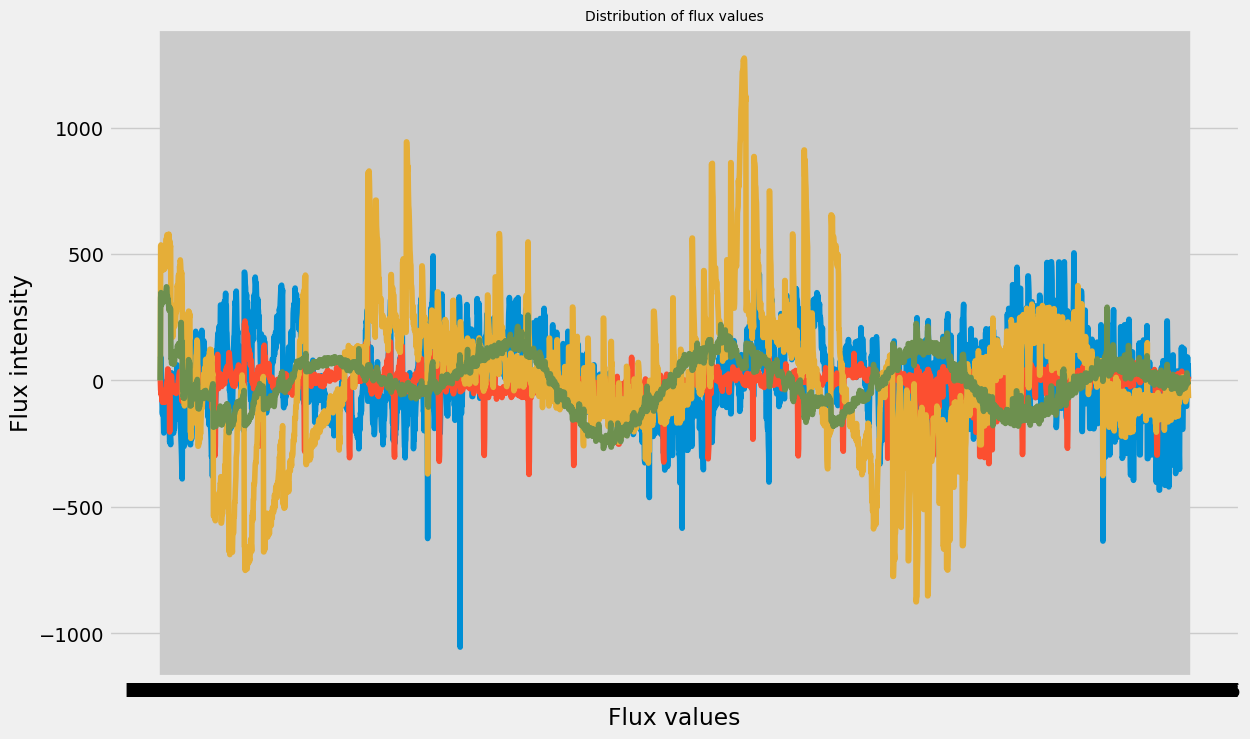

In [14]:
rcParams['figure.figsize'] = 13, 8
plt.title('Distribution of flux values', fontsize=10)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(train_data.iloc[0, :-1])  # excluding label column for plotting
plt.plot(train_data.iloc[1, :-1])
plt.plot(train_data.iloc[2, :-1])
plt.plot(train_data.iloc[3, :-1])
plt.show()


## Histograms of Flux Values for Some Samples


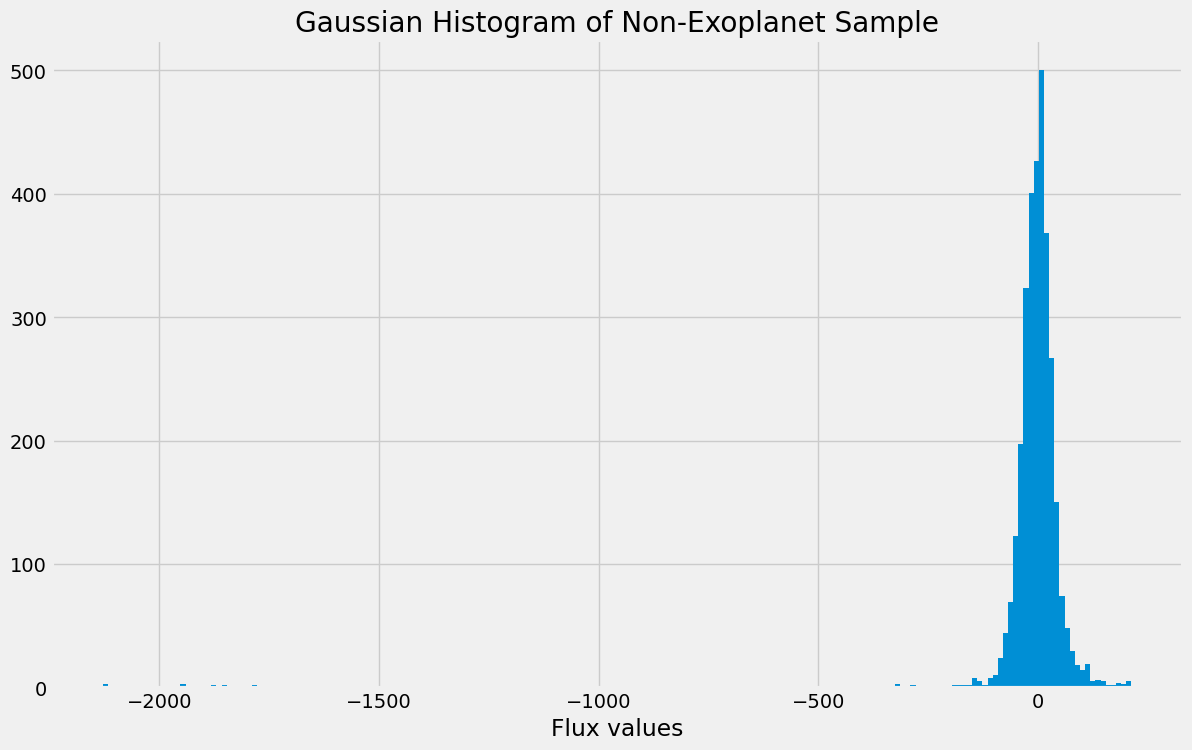

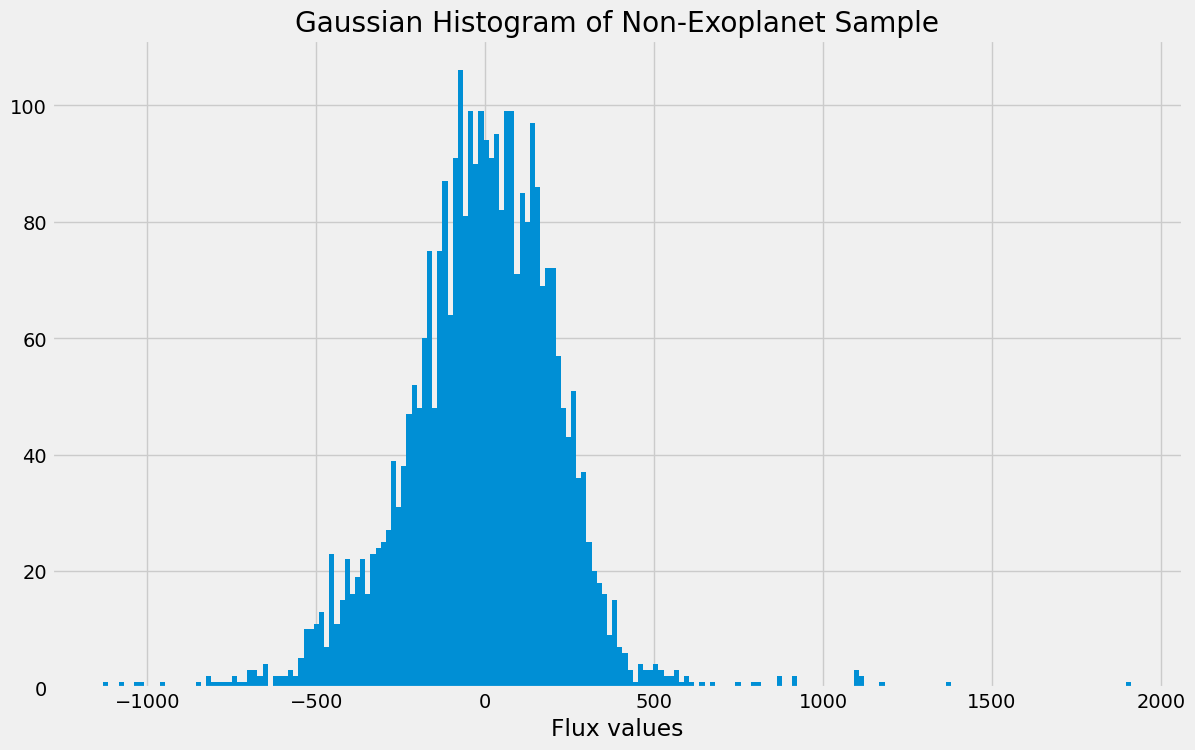

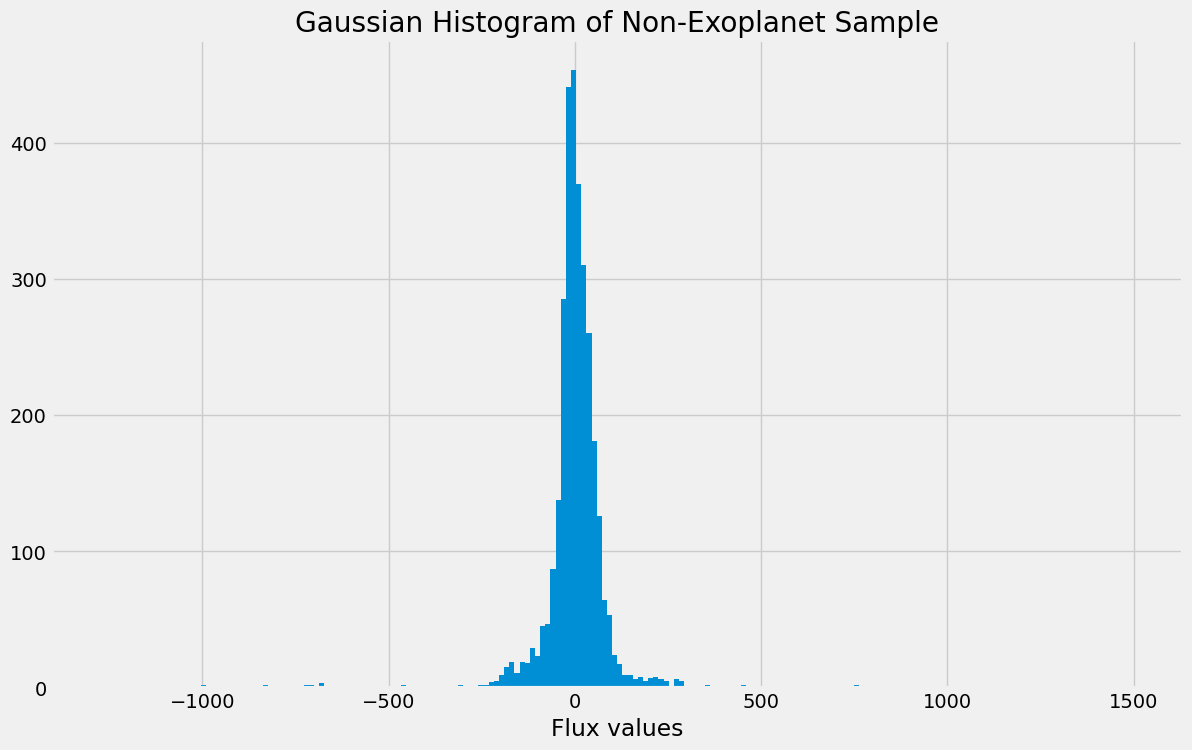

In [19]:
# Gaussian histogram of no exoplanets (label 0)
no_exoplanet_samples = [100, 200, 300]
for i in no_exoplanet_samples:
    plt.hist(train_data.iloc[i, :-1], bins=200)
    plt.title("Gaussian Histogram of Non-Exoplanet Sample")
    plt.xlabel("Flux values")
    plt.show()


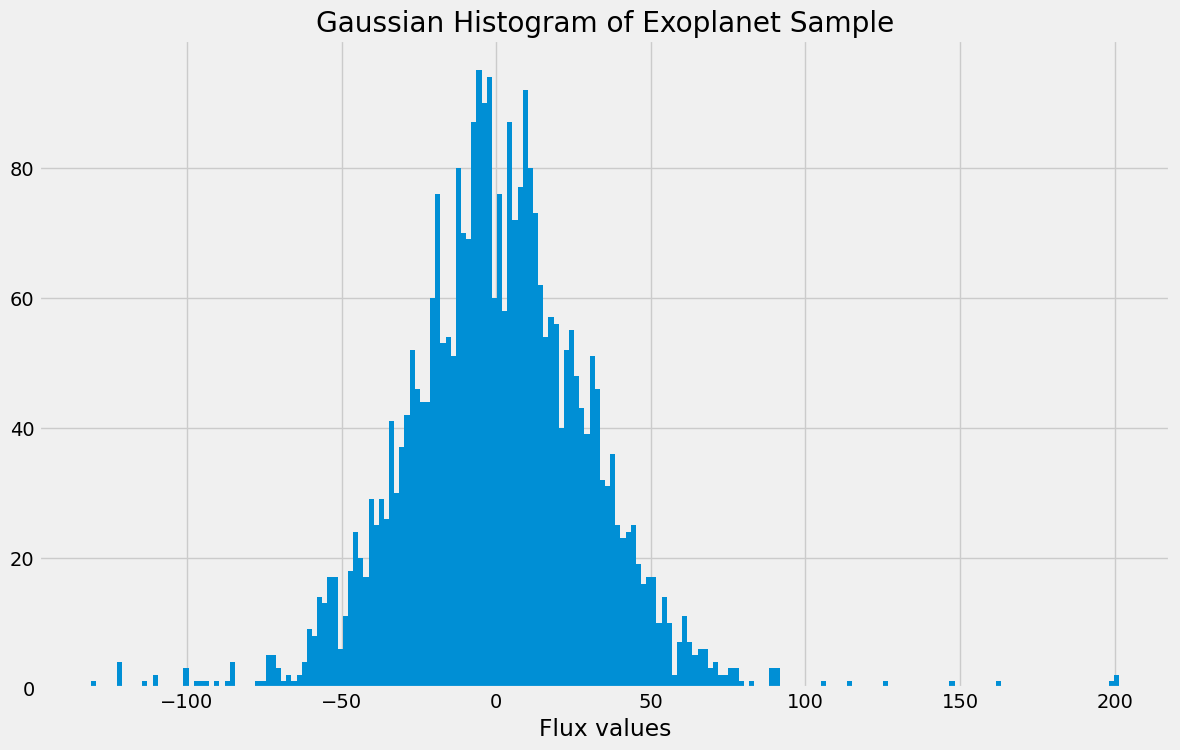

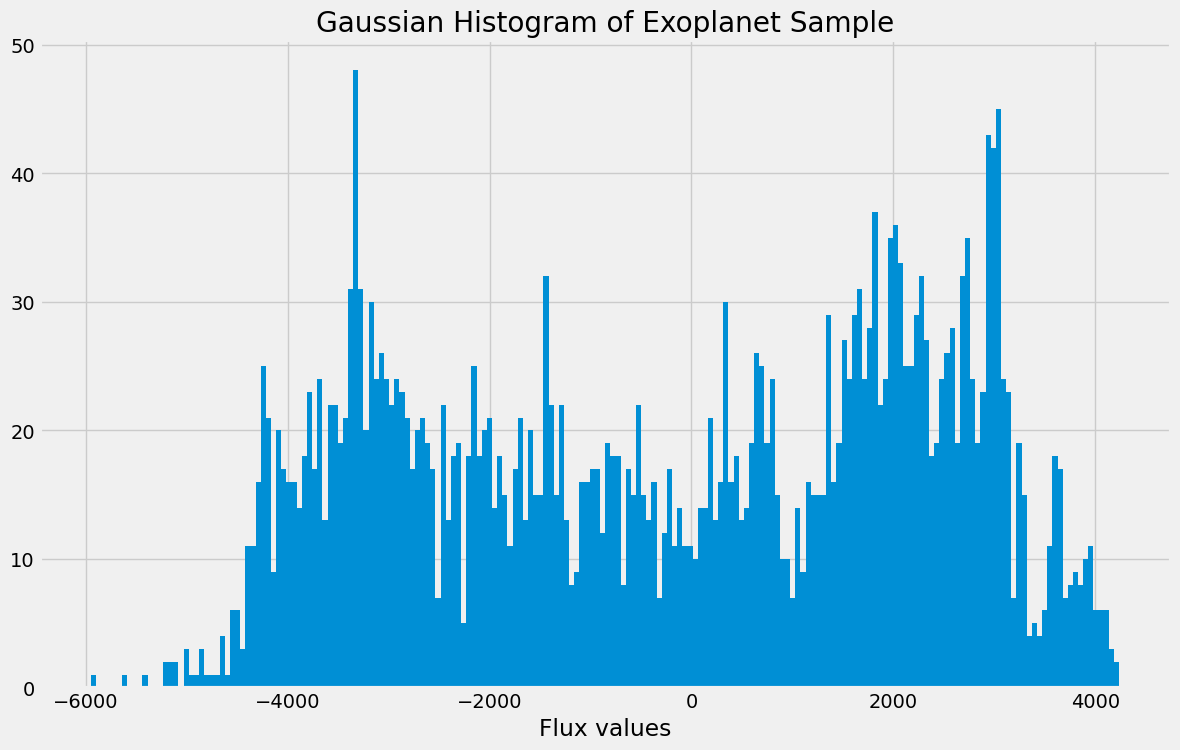

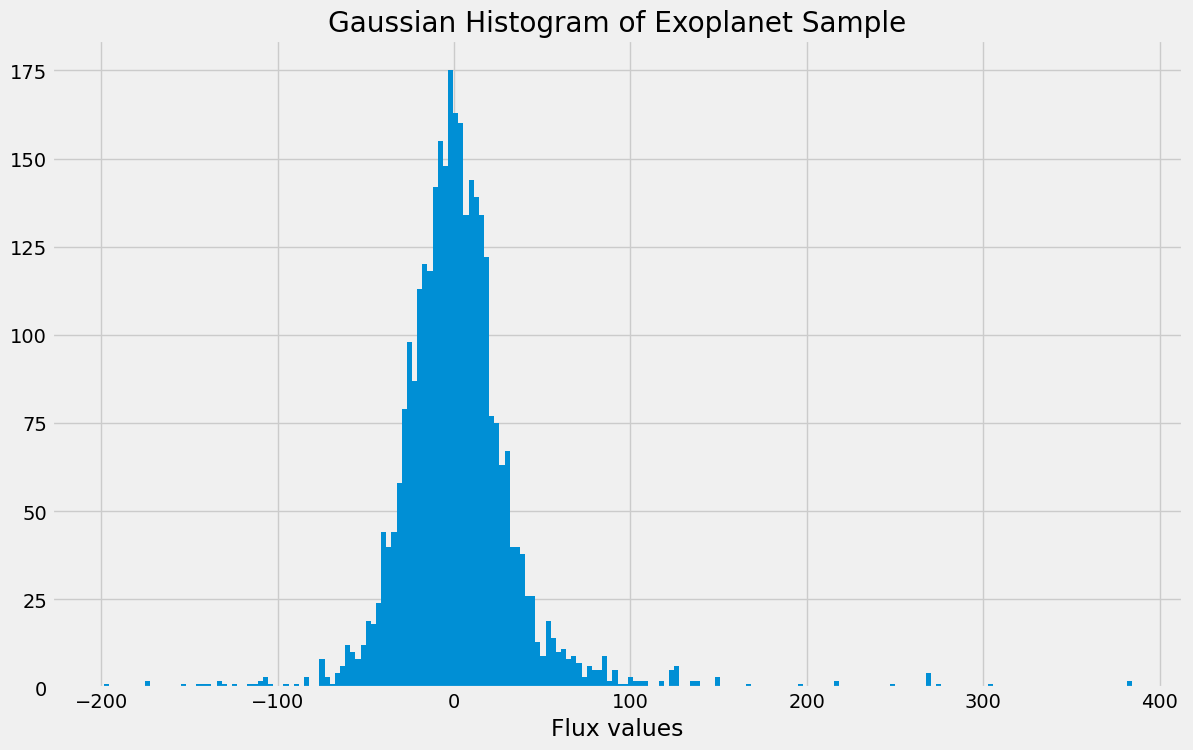

In [21]:
# Gaussian histogram of exoplanets (label 1)
exoplanet_samples = [16, 21, 25]
for i in exoplanet_samples:
    plt.hist(train_data.iloc[i, :-1], bins=200)
    plt.title("Gaussian Histogram of Exoplanet Sample")
    plt.xlabel("Flux values")
    plt.show()


## Splitting and Normalizing Data


In [23]:
x_train = train_data.drop(["LABEL"], axis=1)
y_train = train_data["LABEL"]

x_test = test_data.drop(["LABEL"], axis=1)
y_test = test_data["LABEL"]

# Normalize data
x_train = normalize(x_train)
x_test = normalize(x_test)


## Apply Gaussian Filter to Smooth Data


In [26]:
x_train = ndimage.gaussian_filter(x_train, sigma=10)
x_test = ndimage.gaussian_filter(x_test, sigma=10)


## Feature Scaling with StandardScaler


In [29]:
std_scaler = StandardScaler()
x_train = std_scaler.fit_transform(x_train)
x_test = std_scaler.transform(x_test)  # Use transform here, not fit_transform

## Dimensionality Reduction Using PCA


In [31]:
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)

total_variance = sum(pca.explained_variance_)
current_variance = 0
k = 0
while current_variance / total_variance < 0.70:
    current_variance += pca.explained_variance_[k]
    k += 1

print(f"Number of components to preserve 70% variance: {k}")


Number of components to preserve 70% variance: 16


## Apply PCA with Chosen Number of Components and Plot Explained Variance


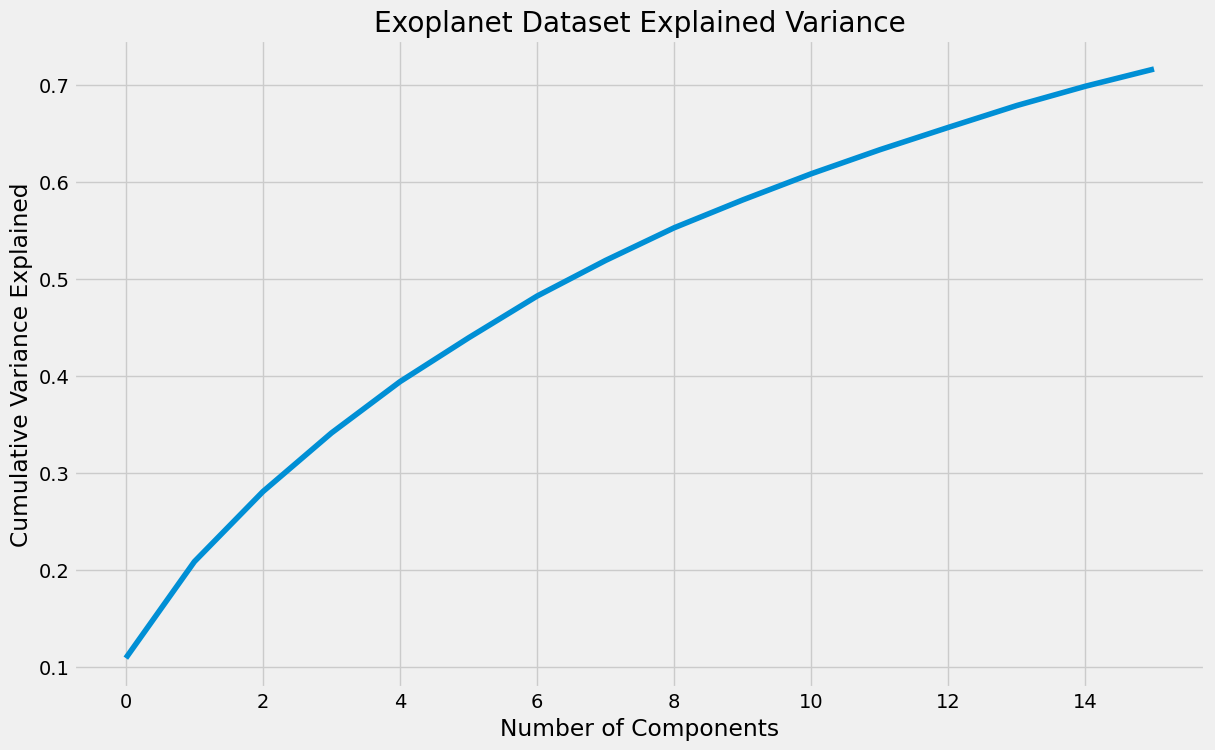

In [34]:
pca = PCA(n_components=k)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Exoplanet Dataset Explained Variance')
plt.show()


## Correlation Heatmap of Principal Components


In [71]:
df = pd.DataFrame(x_train)
corr = df.corr(method='kendall')

plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=False)
plt.title("Correlation Heatmap of PCA Components")
plt.show()



KeyboardInterrupt



## Handle Class Imbalance Using SMOTE


In [72]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=27, sampling_strategy=1.0)  # ratio parameter renamed to sampling_strategy
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))


Before OverSampling, counts of label '1': 37
Before OverSampling, counts of label '0': 5050 

After OverSampling, counts of label '1': 5050
After OverSampling, counts of label '0': 5050


## Artificial Neural Network Model Training and Evaluation


In [73]:
from tensorflow.random import set_seed
set_seed(101)

from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense

def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu', input_dim=x_train_res.shape[1]))
    classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn=build_classifier, epochs=40, batch_size=32, verbose=0)
accuracies = cross_val_score(estimator=classifier, X=x_train_res, y=y_train_res, cv=5, n_jobs=-1)

print("Accuracy mean: ", accuracies.mean())
print("Accuracy variance: ", accuracies.std())


Accuracy mean:  0.9809900999069214
Accuracy variance:  0.01865383786150046


18/18 [==============================] - 0s 2ms/step


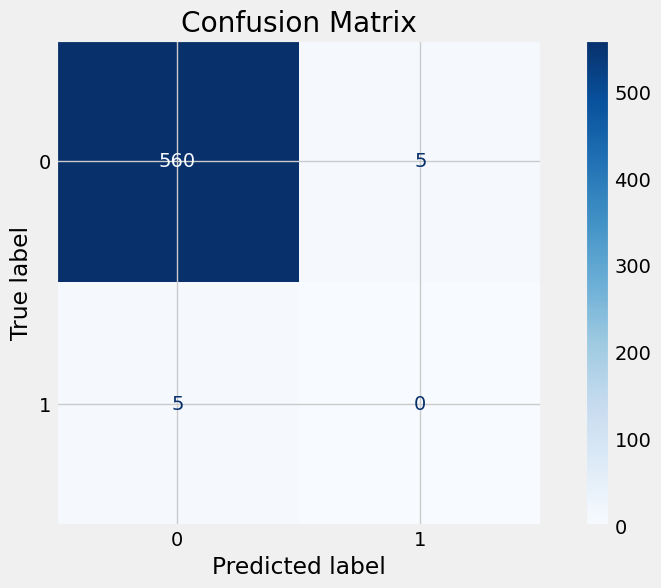

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = build_classifier()
model.fit(x_train_res, y_train_res, epochs=40, verbose=0)
y_pred = (model.predict(x_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


## Implementation of random forest to compare

Confusion Matrix:
[[565   0]
 [  5   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



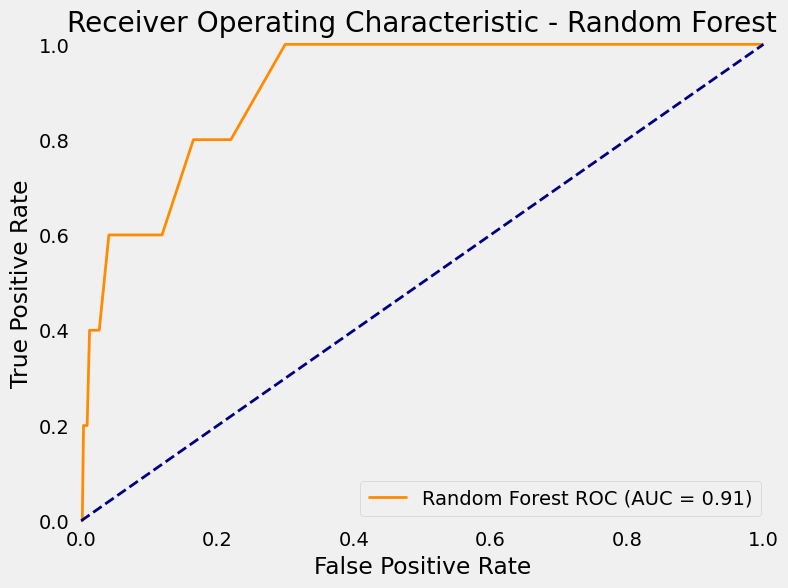

In [75]:
# RANDOM FOREST IMPLEMENTATION
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Train the Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_res, y_train_res)

# Predict on test set
y_pred_rf = rf.predict(x_test)
y_prob_rf = rf.predict_proba(x_test)[:,1]

# Print metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Random Forest ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.grid()
plt.show()
